# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2"))

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from IPython.display import Image, display

from libs.isic import load
from libs.fractal_percolation_module import FractalModule
from libs.auc import calculate_auc
from libs.gradcam import display_gradcam, make_gradcam_heatmap, get_img_array

In [3]:
tf.get_logger().setLevel('ERROR')

## Hyperparameter definition

In [4]:
strategy = tf.distribute.MirroredStrategy()

In [5]:
with strategy.scope():
    EPOCHS = 200
    SAMPLE_NUMBER = None
    
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    FRACTAL_WIDTH, FRACTAL_HEIGHT = 10, 10
    FRACTAL_MODULE = FractalModule(FRACTAL_WIDTH, FRACTAL_HEIGHT)
    O_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    F_MODEL = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(TARGET_WIDTH, TARGET_HEIGHT, 3),
        pooling='avg'
    )
    RETRAINABLE_LAYERS = ['conv2d_202', 'block8_10_conv', 'conv_7b']
    PREPROCESSING = tf.keras.applications.inception_resnet_v2.preprocess_input

## Load the ISIC Archive dataset

In [6]:
(training_set, validation_set, testing_set), class_weights, class_number = load(SAMPLE_NUMBER)

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/experiment--2/libs/isic/load.py:8: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


## Model definition

In [7]:
class LesionClassifier(tf.keras.Model):
    def __init__(self):
        super(LesionClassifier, self).__init__()
        
        self.fractal_module = FRACTAL_MODULE
        
        self.resize = tf.keras.layers.Resizing(
            width=TARGET_WIDTH,
            height=TARGET_HEIGHT
        )
        
        self.rescale = tf.keras.layers.Rescaling(scale=1. / 255)
        
        self.o_model = O_MODEL
        for layer in self.o_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.f_model = F_MODEL
        for layer in self.f_model.layers:
            if layer.name in RETRAINABLE_LAYERS:
                layer.trainable = True
        else:
            layer.trainable = False
            
        self.fusion = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        f_outputs = self.fractal_module(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)

        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)

        outputs = self.fusion([f_outputs, o_outputs])
        outputs = self.dense(outputs)

        return outputs

In [8]:
checkpoint_path = 'checkpoint'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [9]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=15, 
    restore_best_weights=True
)

In [10]:
time_stopping = tfa.callbacks.TimeStopping(seconds=65 * 3600)

## Training

In [11]:
with strategy.scope():
    model = LesionClassifier()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=EPOCHS,
    callbacks=[
        checkpoint_callback,
        early_stop_callback,
        time_stopping
    ]
)

Epoch 1/200
947/947 [==============================] - ETA: 0s - loss: 0.8162 - accuracy: 0.7291

947/947 [==============================] - 5706s 6s/step - loss: 0.8162 - accuracy: 0.7291 - val_loss: 1.1996 - val_accuracy: 0.6950
Epoch 2/200
947/947 [==============================] - ETA: 0s - loss: 0.7158 - accuracy: 0.7540

947/947 [==============================] - 5286s 6s/step - loss: 0.7158 - accuracy: 0.7540 - val_loss: 0.7404 - val_accuracy: 0.7414
Epoch 3/200
947/947 [==============================] - 4833s 5s/step - loss: 0.6629 - accuracy: 0.7720 - val_loss: 0.7633 - val_accuracy: 0.7407
Epoch 4/200
947/947 [==============================] - ETA: 0s - loss: 0.6148 - accuracy: 0.7866

947/947 [==============================] - 5225s 6s/step - loss: 0.6148 - accuracy: 0.7866 - val_loss: 0.6465 - val_accuracy: 0.7786
Epoch 5/200
947/947 [==============================] - ETA: 0s - loss: 0.5899 - accuracy: 0.7933

947/947 [==============================] - 5209s 6s/step - loss: 0.5899 - accuracy: 0.7933 - val_loss: 0.6382 - val_accuracy: 0.7654
Epoch 6/200
947/947 [==============================] - 4836s 5s/step - loss: 0.5635 - accuracy: 0.8027 - val_loss: 0.7205 - val_accuracy: 0.7522
Epoch 7/200
947/947 [==============================] - ETA: 0s - loss: 0.5432 - accuracy: 0.8058

947/947 [==============================] - 5274s 6s/step - loss: 0.5432 - accuracy: 0.8058 - val_loss: 0.6042 - val_accuracy: 0.7856
Epoch 8/200
947/947 [==============================] - ETA: 0s - loss: 0.5199 - accuracy: 0.8146

947/947 [==============================] - 5314s 6s/step - loss: 0.5199 - accuracy: 0.8146 - val_loss: 0.5566 - val_accuracy: 0.7980
Epoch 9/200
947/947 [==============================] - 4886s 5s/step - loss: 0.5083 - accuracy: 0.8183 - val_loss: 0.5608 - val_accuracy: 0.8043
Epoch 10/200
947/947 [==============================] - ETA: 0s - loss: 0.4888 - accuracy: 0.8279

947/947 [==============================] - 5313s 6s/step - loss: 0.4888 - accuracy: 0.8279 - val_loss: 0.5135 - val_accuracy: 0.8165
Epoch 11/200
947/947 [==============================] - 4889s 5s/step - loss: 0.4701 - accuracy: 0.8323 - val_loss: 1.0581 - val_accuracy: 0.7302
Epoch 12/200
947/947 [==============================] - 4834s 5s/step - loss: 0.4559 - accuracy: 0.8357 - val_loss: 0.5336 - val_accuracy: 0.8143
Epoch 13/200
947/947 [==============================] - ETA: 0s - loss: 0.4403 - accuracy: 0.8433

947/947 [==============================] - 5232s 6s/step - loss: 0.4403 - accuracy: 0.8433 - val_loss: 0.5086 - val_accuracy: 0.8241
Epoch 14/200
947/947 [==============================] - 4998s 5s/step - loss: 0.4244 - accuracy: 0.8494 - val_loss: 0.5871 - val_accuracy: 0.7896
Epoch 15/200
947/947 [==============================] - ETA: 0s - loss: 0.4104 - accuracy: 0.8508

947/947 [==============================] - 5274s 6s/step - loss: 0.4104 - accuracy: 0.8508 - val_loss: 0.4813 - val_accuracy: 0.8270
Epoch 16/200
947/947 [==============================] - ETA: 0s - loss: 0.4020 - accuracy: 0.8544

947/947 [==============================] - 5294s 6s/step - loss: 0.4020 - accuracy: 0.8544 - val_loss: 0.4754 - val_accuracy: 0.8274
Epoch 17/200
947/947 [==============================] - 4970s 5s/step - loss: 0.3798 - accuracy: 0.8609 - val_loss: 0.5134 - val_accuracy: 0.8206
Epoch 18/200
947/947 [==============================] - 5004s 5s/step - loss: 0.3719 - accuracy: 0.8652 - val_loss: 0.4793 - val_accuracy: 0.8375
Epoch 19/200
947/947 [==============================] - 4914s 5s/step - loss: 0.3551 - accuracy: 0.8696 - val_loss: 0.4902 - val_accuracy: 0.8291
Epoch 20/200
947/947 [==============================] - 4900s 5s/step - loss: 0.3397 - accuracy: 0.8762 - val_loss: 0.5289 - val_accuracy: 0.8163
Epoch 21/200
947/947 [==============================] - 4899s 5s/step - loss: 0.3314 - accuracy: 0.8787 - val_loss: 0.4817 - val_accuracy: 0.8350
Epoch 22/200
947/947 [==============================] - 4847s 5s/step - loss: 0.3188 - accuracy: 0.8832 - val_loss: 0.4831 - val_accuracy

947/947 [==============================] - 5242s 6s/step - loss: 0.3029 - accuracy: 0.8870 - val_loss: 0.4518 - val_accuracy: 0.8435
Epoch 24/200
947/947 [==============================] - 4840s 5s/step - loss: 0.2917 - accuracy: 0.8931 - val_loss: 0.4755 - val_accuracy: 0.8411
Epoch 25/200
947/947 [==============================] - 4954s 5s/step - loss: 0.2841 - accuracy: 0.8950 - val_loss: 0.5240 - val_accuracy: 0.8283
Epoch 26/200
947/947 [==============================] - 4911s 5s/step - loss: 0.2811 - accuracy: 0.8974 - val_loss: 0.5358 - val_accuracy: 0.8245
Epoch 27/200
947/947 [==============================] - 4893s 5s/step - loss: 0.2624 - accuracy: 0.9037 - val_loss: 0.5491 - val_accuracy: 0.8286
Epoch 28/200
947/947 [==============================] - 4841s 5s/step - loss: 0.2462 - accuracy: 0.9072 - val_loss: 0.5523 - val_accuracy: 0.8283
Epoch 29/200
947/947 [==============================] - 5021s 5s/step - loss: 0.2458 - accuracy: 0.9092 - val_loss: 0.5082 - val_accuracy

## Testing

In [13]:
model.load_weights(checkpoint_path)

In [14]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [15]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 467s 3s/step


In [16]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [17]:
auc_metric

{'actinic keratosis': 0.9826873245842385,
 'basal cell carcinoma': 0.9857770781848579,
 'dermatofibroma': 0.9832373999719219,
 'melanoma': 0.9336922962189573,
 'nevus': 0.9641273115184439,
 'pigmented benign keratosis': 0.9837698938281447,
 'seborrheic keratosis': 0.9591072796703727,
 'solar lentigo': 0.929665071770335,
 'squamous cell carcinoma': 0.9664117185614289,
 'vascular lesion': 0.9964011516314779}

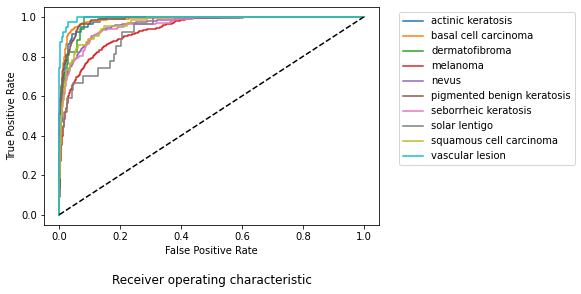

In [18]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

## GradCam

In [19]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

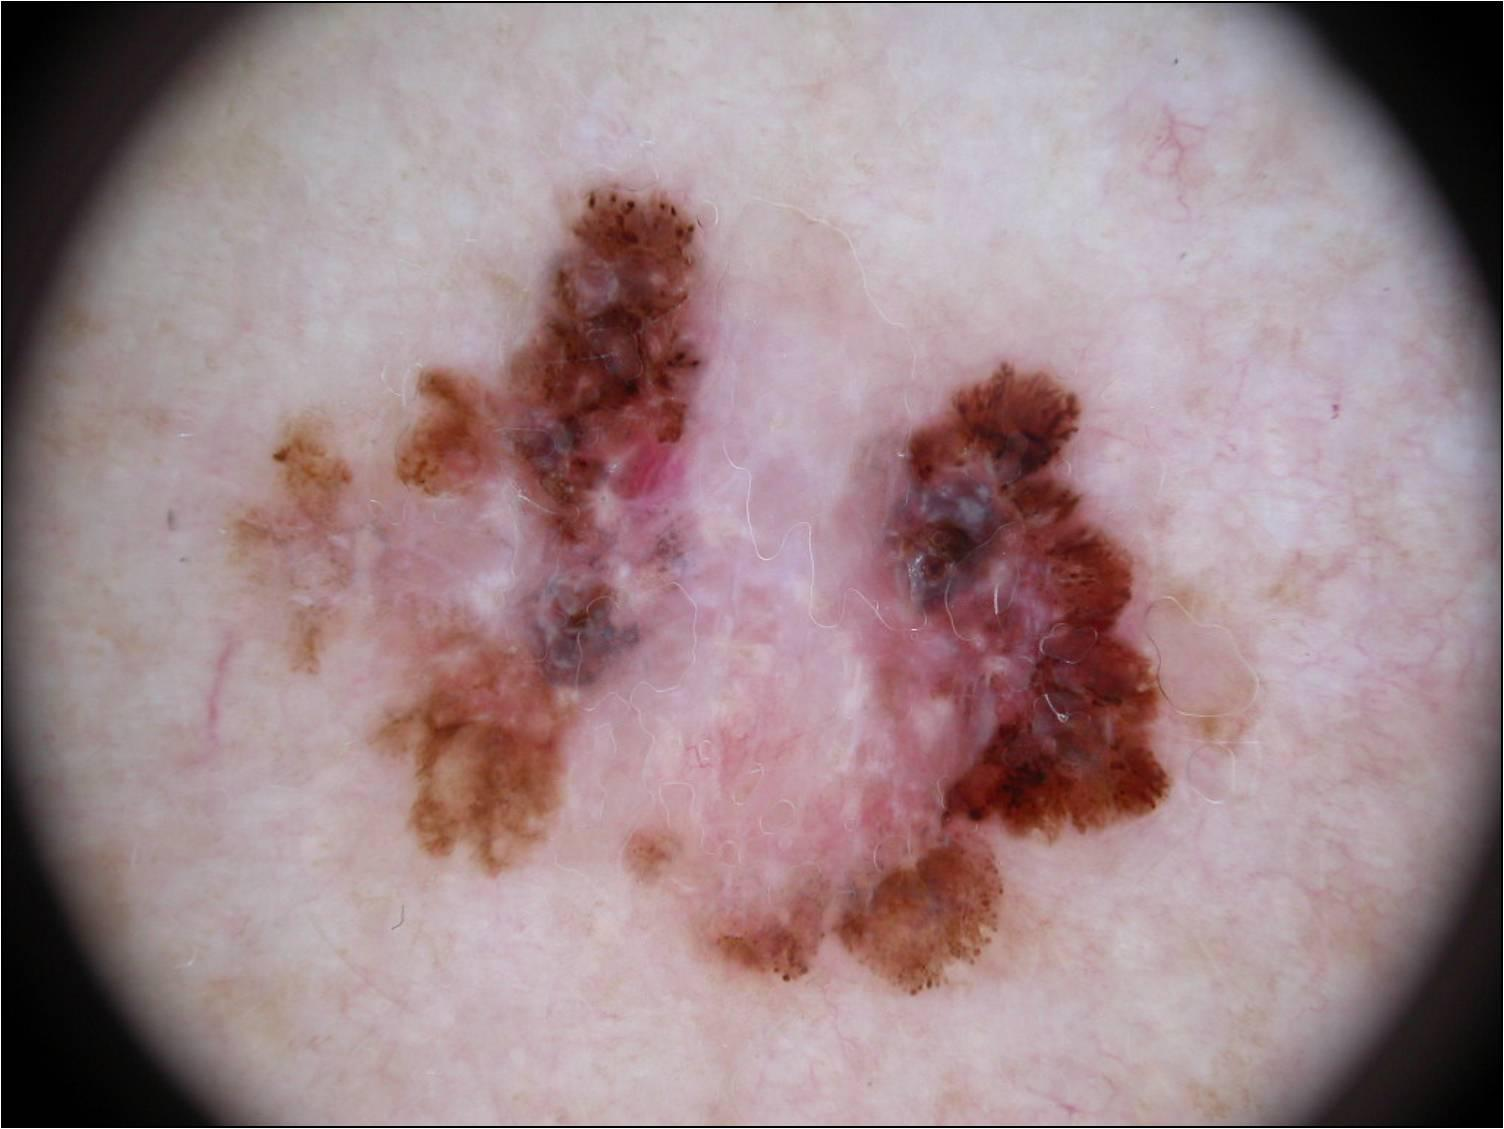

In [20]:
display(Image(melanoma_im_path, width=600))

In [21]:
img_array = PREPROCESSING(get_img_array(melanoma_im_path, size=(299, 299)))

In [22]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, RETRAINABLE_LAYERS[-1])

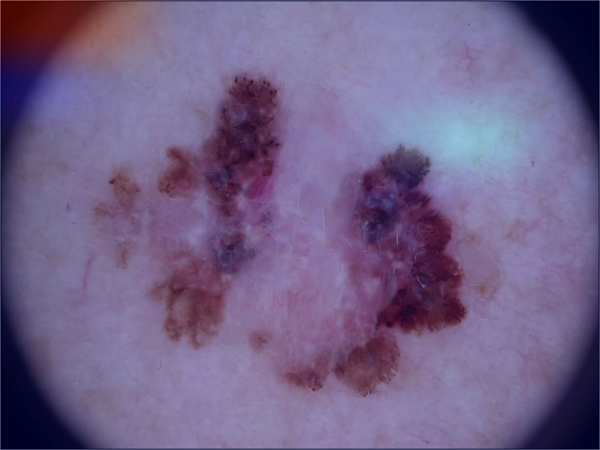

In [23]:
display_gradcam(melanoma_im_path, heatmap)